<a href="https://colab.research.google.com/github/mustafabozkaya/DeepLearningBootcamp2022/blob/master/Bootcamp_Solution/Spectogram_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img align="Left" width="100" height="100" src="https://thumbs.dreamstime.com/b/mb-initial-letter-vector-logo-icon-mb-initial-letter-vector-logo-icon-204517753.jpg">](https://github.com/mustafabozkaya)

# Spectogram Recognition with CNN

---
[<img align="Left" width="800" height="300" src="https://www.researchgate.net/publication/319081627/figure/fig1/AS:534034566004736@1504335170521/Spectrogram-of-a-speech-signal-with-breath-sound-marked-as-Breath-whose-bounds-are.png">](#)



**Colab** için kimlik doğrulama adımları:

**Drive yükleme işlemi**

**Drive da dosya konumlandırmayı yapma işlemleri**

In [1]:
from google.colab import drive
drive.mount('/content/mydrive/',force_remount=True)

Mounted at /content/mydrive/


In [2]:
!pwd


/content


In [3]:
%cd /content

/content


In [4]:
!pwd

/content


In [5]:
#Copying current content to new editable directory
#!cp -r "../content/drive/MyDrive/spectrograms/" "/sample_data/"


+
# Package İnstalling and Controlling

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6088549649489739304
 xla_global_id: -1]

In [7]:
#!cat /proc/meminfo

In [8]:
!pip install -q keras
!pip install -q Pillow

In [9]:
import tensorflow as tf
tf.test.gpu_device_name()


''

In [10]:
tf.__version__

'2.8.2'

In [11]:
#https://github.com/astrada/google-drive-ocamlfuse/
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !ls

In [12]:
!ls ../content

mydrive  sample_data


In [13]:
from __future__ import print_function
import PIL
import PIL.Image
import tensorflow_datasets as tfds

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import glob
import numpy as np
import os
import shutil
import pathlib
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"]=(18,8)
%matplotlib inline
np.random.seed(42)

In [14]:
cv.__version__

'4.6.0'

# Configuring İmage datasets folder 

In [15]:
!ls

mydrive  sample_data


In [16]:
dataset_dir=f"/content/mydrive/My Drive/spectrograms/"


In [17]:
data_dir = pathlib.Path(dataset_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8732


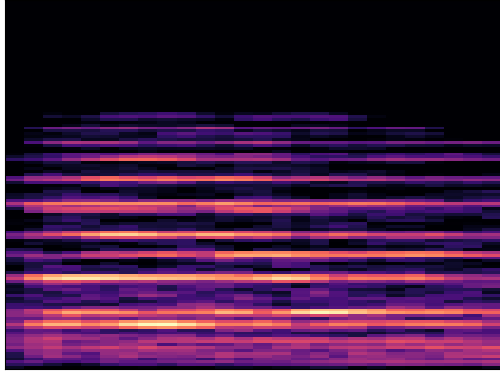

In [18]:
spec = list(data_dir.glob('1/*'))
PIL.Image.open(str(spec[6]))

In [ ]:
for root, dirs, files in os.walk(dataset_dir, topdown=True):
    print("="*50)
    print(root)
    print(f"root type :{type(files)}")
    print(f"root lenth :{len(files)}")
    print(files)
    print(f"files type :{type(files)}")
    print(f"files lenth :{len(files)}")
    print(dirs)
    print(f"DİR type :{type(dirs)}")
    print(f"DİR lenth :{len(dirs)}")
    print("="*50)
    break
    

In [20]:
for root,dirs, files in os.walk(dataset_dir):
    for file in (files):
        print(os.path.join(root, file))
        break
    

/content/mydrive/My Drive/spectrograms/6/102305-6-0-0.png
/content/mydrive/My Drive/spectrograms/5/102857-5-0-0.png
/content/mydrive/My Drive/spectrograms/2/100263-2-0-117.png
/content/mydrive/My Drive/spectrograms/1/100648-1-2-0.png
/content/mydrive/My Drive/spectrograms/3/100032-3-0-0.png
/content/mydrive/My Drive/spectrograms/8/102853-8-0-0.png
/content/mydrive/My Drive/spectrograms/9/101848-9-0-3.png
/content/mydrive/My Drive/spectrograms/0/100852-0-0-10.png
/content/mydrive/My Drive/spectrograms/4/103199-4-0-5.png
/content/mydrive/My Drive/spectrograms/7/103074-7-0-0.png


In [21]:
images = []
number_of_errors = 0
number_of_processed = 0

for classid in os.listdir(dataset_dir):
    #print(classid)
    path_to_class = f"{dataset_dir}/{classid}"
    for image in os.listdir(path_to_class):
        #print(image)
        try:
            path_to_image = f"{path_to_class}/{image}"
            
            img = cv.imread(path_to_image, 0)
            img = cv.resize(img, (128,128))
            img = img/255
            images.append([img, int(classid)])
            number_of_processed += 1

        except:
            number_of_errors += 1
        
    print(f"\r Processed: {number_of_processed} | Erros: {number_of_errors} -- class id :{classid}  image :{image}", end="")

 Processed: 8732 | Erros: 0 -- class id :7  image :98859-7-2-3.png

In [22]:
len(images)

8732

In [23]:
for image ,id in images:
  print(f"\r class id :{id}  image :{image.shape}", end="")

 class id :7  image :(128, 128)

# Data Exploration

In [24]:

class_name="1" # set to class name

train_files = glob.glob(str(os.path.join(dataset_dir,str(class_name)))+'/*')


print(*train_files)
print(f"1 spectogram img lenth :{len(train_files)}")
train_imgs = [img_to_array(load_img(img)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = np.array([fn.split('/')[5].split(".")[0].strip() for fn in train_files]) # target , y label

print('Train dataset shape:', train_imgs.shape)
print('Train labels shape:', train_labels.shape)

/content/mydrive/My Drive/spectrograms/1/100648-1-2-0.png /content/mydrive/My Drive/spectrograms/1/100648-1-1-0.png /content/mydrive/My Drive/spectrograms/1/100648-1-0-0.png /content/mydrive/My Drive/spectrograms/1/100648-1-3-0.png /content/mydrive/My Drive/spectrograms/1/100648-1-4-0.png /content/mydrive/My Drive/spectrograms/1/107090-1-1-0.png /content/mydrive/My Drive/spectrograms/1/107090-1-0-0.png /content/mydrive/My Drive/spectrograms/1/117536-1-0-0.png /content/mydrive/My Drive/spectrograms/1/118070-1-0-0.png /content/mydrive/My Drive/spectrograms/1/118496-1-0-0.png /content/mydrive/My Drive/spectrograms/1/118496-1-1-0.png /content/mydrive/My Drive/spectrograms/1/121299-1-0-0.png /content/mydrive/My Drive/spectrograms/1/125520-1-4-0.png /content/mydrive/My Drive/spectrograms/1/125520-1-1-0.png /content/mydrive/My Drive/spectrograms/1/125520-1-3-0.png /content/mydrive/My Drive/spectrograms/1/125520-1-0-0.png /content/mydrive/My Drive/spectrograms/1/125520-1-2-0.png /content/mydri

In [25]:
# create image datasets 

In [26]:
image_size=(374,500)
batch_size=32 # paketler

#Setting train/test split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    
    directory=dataset_dir,
    labels="inferred",
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_dir,
    labels="inferred",
    validation_split=0.3,
    subset="validation",
    seed=1007,
    image_size=image_size,
    batch_size=batch_size,
)



Found 8732 files belonging to 10 classes.
Using 6113 files for training.
Found 8732 files belonging to 10 classes.
Using 2619 files for validation.


In [27]:
print(f"{train_ds.class_names}")

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [28]:
# print how many images are in the training and validation datasets
print("Number of training images: ", len(train_ds))
print("Number of validation images: ", len(valid_ds))

Number of training images:  192
Number of validation images:  82


In [29]:
# split valid dataset to test and valid
test_ds = valid_ds.take(30) # get 100 data from valid dataset
valid_ds = valid_ds.skip(30) # skip first 100

In [30]:
# how many bachs are in the training and validation datasets
print("Number of training batches: ", len(train_ds))
print("Number of validation batches: ", len(valid_ds))
print("Number of test  batches: ", len(test_ds))

Number of training batches:  192
Number of validation batches:  52
Number of test  batches:  30


In [31]:
dataset_type=[train_ds,valid_ds,test_ds]

In [32]:
for ds in dataset_type:
  print(type(ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>


In [33]:
#Checking images and labels shapes (amount of images, height, width, color channels)
for image_batch, labels_batch in test_ds.take(2):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 374, 500, 3)
(32,)


In [34]:
#Checking images and labels shapes (amount of images, height, width, color channels)
for image_batch, labels_batch in valid_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 374, 500, 3)
(32,)


# Data Visualizaiton

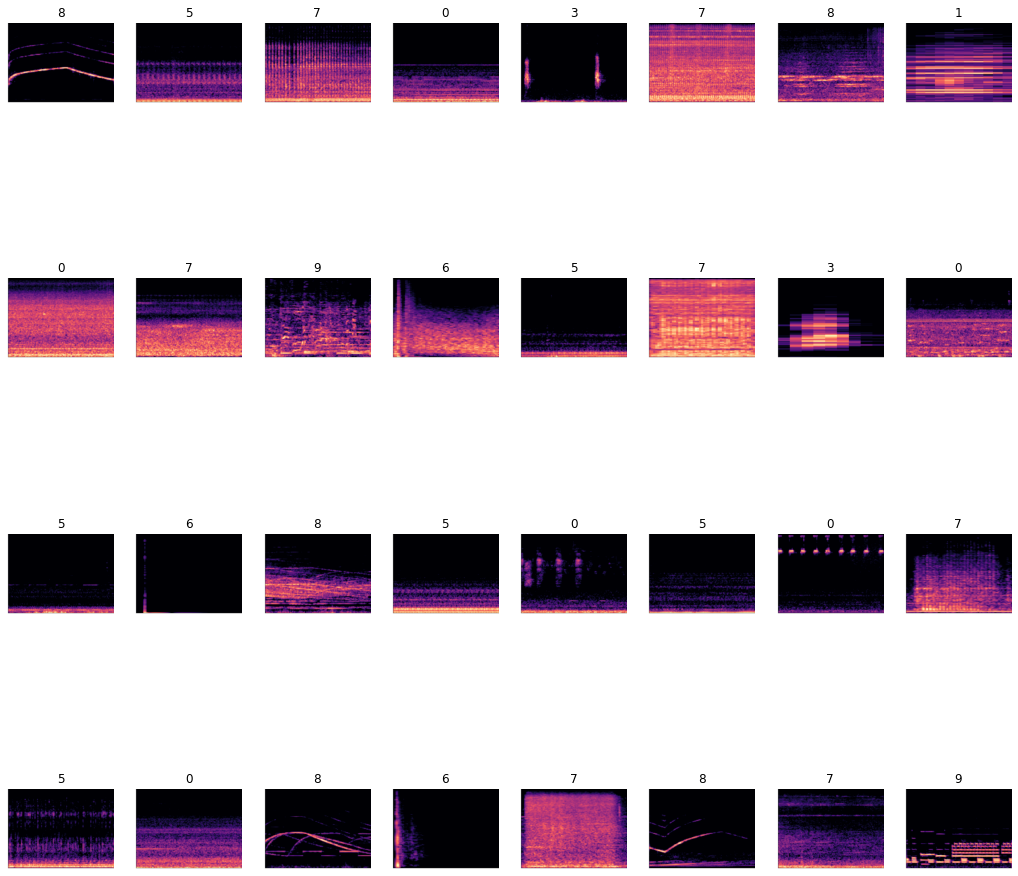

In [35]:
#Displaying image samples 
plt.figure(figsize=(18, 18))
for images, labels in train_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

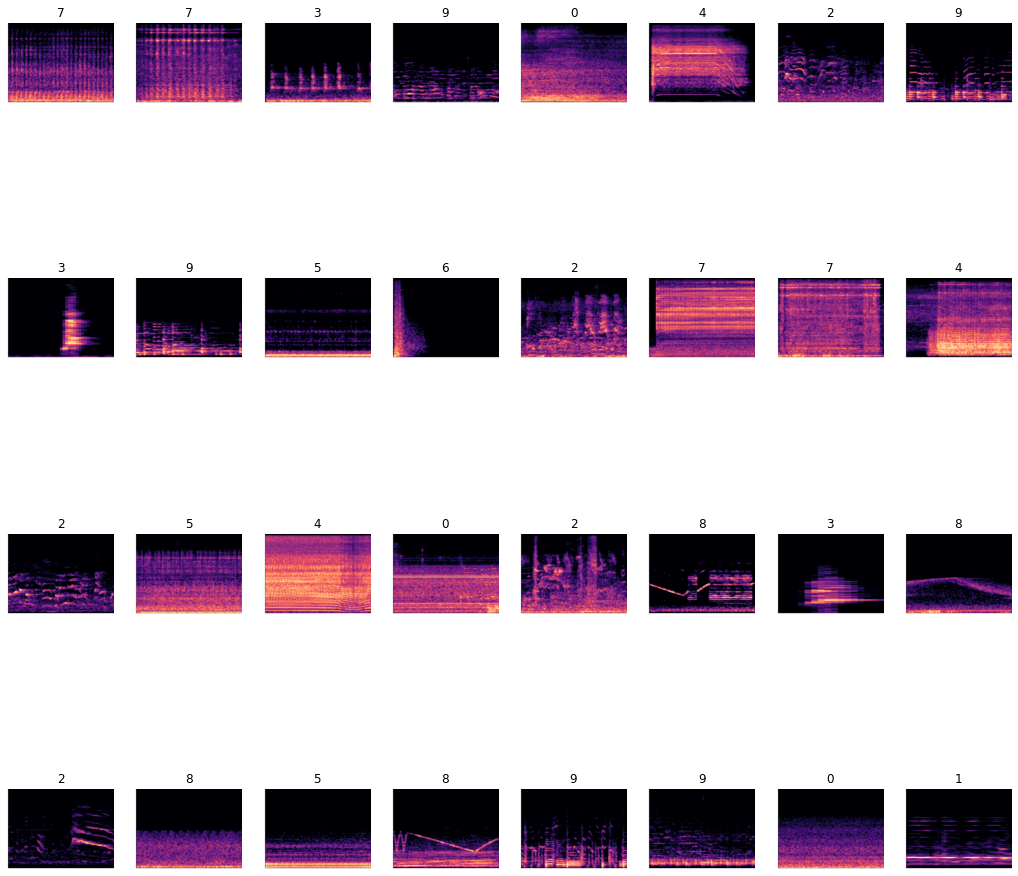

In [36]:
#Displaying image samples 
plt.figure(figsize=(18, 18))
for images, labels in valid_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

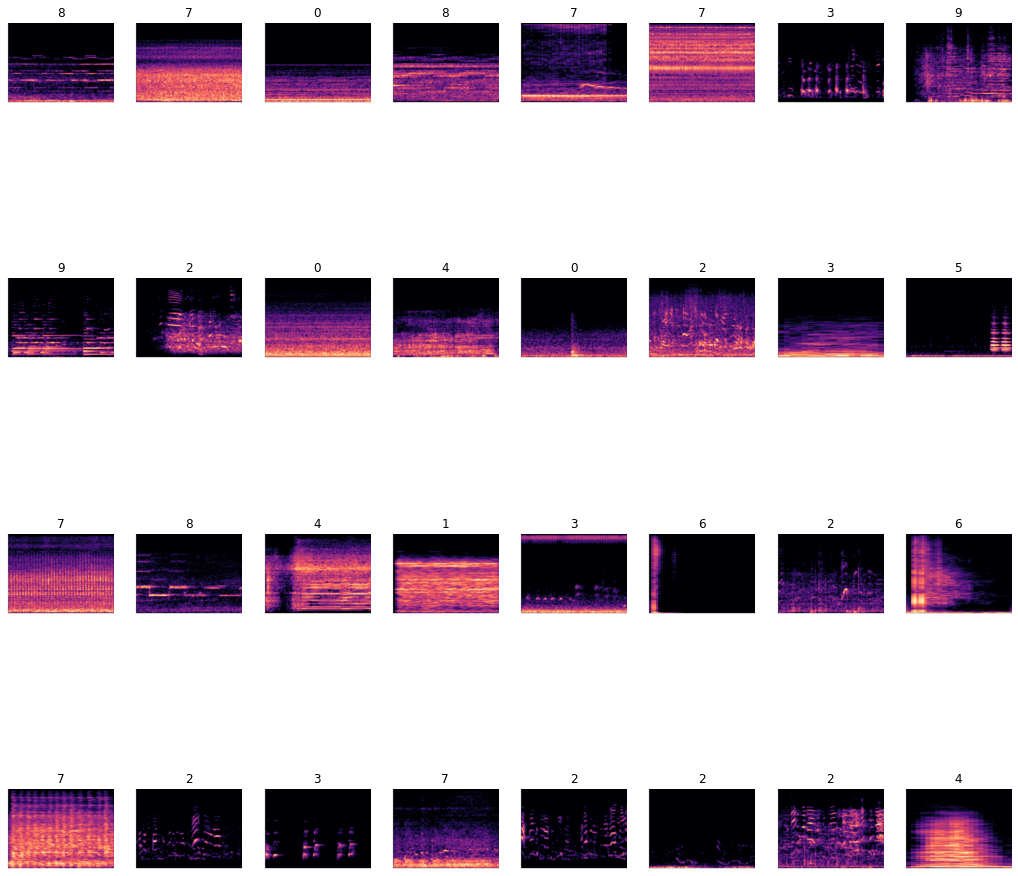

In [37]:
#Displaying image samples 
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(4,8,i+1)
        #print(f"type image {images[i]}")
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data Preprocessing

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We rescale an input in the (0, 255) range to be in the (0,1) range.

In [38]:


# convert rgb img to gray scale img
def convert_to_gray_scale(img):
   
    img = tf.image.rgb_to_grayscale(img)
   
    print(f"\r convert gray :  image shape : {img.shape} | img type: {type(img)} ", end="")
    return img



In [39]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False, batch_size=None, resized_size=None,grayscale=True):
    # Define normalisation function
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    # gray_scale transfpormayion 
    resize=tf.keras.Sequential(
        [tf.keras.layers.experimental.preprocessing.Resizing(
            resized_size[0],
            resized_size[1],
            crop_to_aspect_ratio=True,
        )]
    )
     #define data augmentation function
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    if grayscale:
        ds = ds.map(lambda x, y: (convert_to_gray_scale(x), y))
    if resized_size:
        ds = ds.map(lambda x, y: (resize(x, training=True), y))

  
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(ds))
    print(f"batch size :{image_batch.shape}")
    print(f"label size :{labels_batch.shape}")
    first_image = image_batch[0]
    # Notice the pixel values are now in `[0,1]`.
    print(np.min(first_image), np.max(first_image))

    if augment:
        ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))

        
    
    
    return ds

image_size= (187,250)
train_dataset = prepare(train_ds, augment=False, batch_size=batch_size, resized_size=image_size)
valid_dataset = prepare(test_ds, augment=False, batch_size=batch_size, resized_size=image_size)
test_dataset = prepare(valid_ds, augment=False, batch_size=batch_size, resized_size=image_size)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: list index out of range
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: list index out of range
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 convert gray :  image shape : (None, 374, 500, 1) | img type: <class 'tensorflow.python.framework.ops.Tensor'> batch size :(32, 187, 250, 1)
label size :(32,)
0.0005588236 0.9999001
 convert gray :  image shape : (None, 374, 500, 1) | img type: <class 'tensorflow.python.framework.ops.Tensor'> batch size :(32, 187, 250, 1)
label size :(32,)
0.0005588236 0.9999001
 convert gray :  image shape : (None, 374, 500, 1) | img type: <class 'tensorflow.python.framework.ops.Tensor'> batch size :(32, 187, 250, 1)
label size :(32,)
0.0005588236 0.9999001


In [40]:
for image_batch, labels_batch in valid_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 187, 250, 1)
(32,)


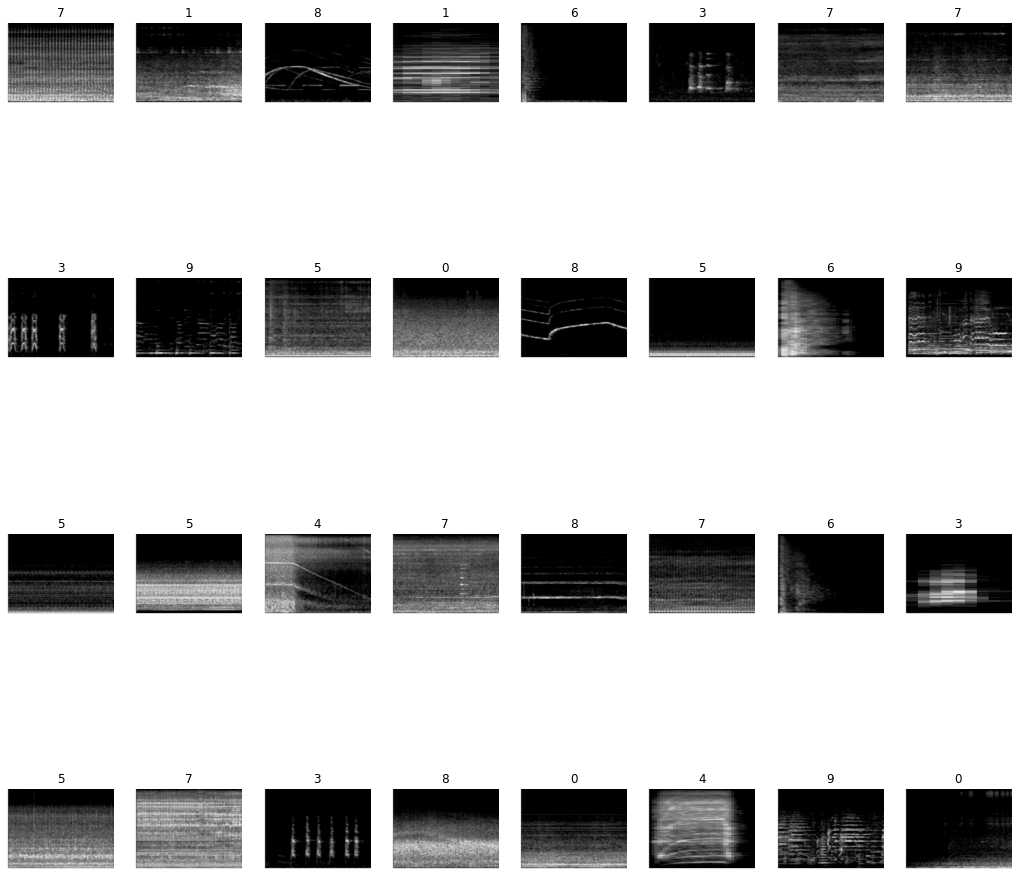

In [41]:
#Displaying image samples 
plt.figure(figsize=(18, 18))
for images, labels in train_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        #print(f"type image {images[i]}")
        plt.imshow(images[i].numpy().squeeze(axis=2),cmap="gray")
        plt.title(int(labels[i]))
        plt.axis("off")

# Modelling

In [42]:
#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.
from keras import backend as K
image_size= (187,250)
img_height=image_size[0]
img_width=image_size[1]
if K.image_data_format() == "channels_first":
    input_shape = (1, img_height, img_width)
else:
    input_shape = (img_height, img_width, 1)


In [43]:
def conv_net(select_model=1): 
  model = tf.keras.Sequential()
  if select_model==1:

    model.add(tf.keras.layers.Conv2D(96, kernel_size = (3,3), input_shape = input_shape, strides = (4,4), activation = 'relu'))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (3,3),strides = (2,2))) 
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1) ,activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))) 
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))) 

    model.add(tf.keras.layers.Flatten()) 

    model.add(tf.keras.layers.Dense(4096, activation='relu')) 
    model.add(tf.keras.layers.Dropout(0.5)) 
    model.add(tf.keras.layers.Dense(4096, activation='relu')) 
    model.add(tf.keras.layers.Dropout(0.5)) 
    model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))


    model.add(tf.keras.layers.Dense(10, activation='softmax')) 

  elif select_model==2:
    # Create CNN model
  
    model.add(tf.keras.layers.Input(shape=input_shape))

    model.add(tf.keras.layers.Conv2D(
        32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))

  else:

    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)))

    model.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
  
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation="relu"))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
  return model

In [44]:
model_dl=conv_net()

# Model Visualization

In [45]:
model_dl.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 62, 96)        960       
                                                                 
 batch_normalization (BatchN  (None, 47, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 23, 30, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:


# Compile model
model_dl.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model_dl.fit(train_dataset,
          batch_size=batch_size,
          verbose=1,
          epochs=10,
          validation_data=valid_dataset)

Epoch 1/10
192/192 [==============================] - 972s 5s/step - loss: 5.5749 - accuracy: 0.1080 - val_loss: 2.2860 - val_accuracy: 0.1094
Epoch 2/10
192/192 [==============================] - 958s 5s/step - loss: 2.3996 - accuracy: 0.1103 - val_loss: 2.2892 - val_accuracy: 0.0958
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 2.3293 - accuracy: 0.1103

### 

In [ ]:
# model_dl.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))

In [ ]:
# score = model_dl.evaluate(x_test, y_test, verbose=0)
# score = model_dl.evaluate(test_dataset, verbose=0)
# print(f"Loss: {score[0]} - Accuracy: {score[1]}")


# Model Saving

In [ ]:
model_test = model_dl.save('save_models/spectogram_model.h5')

# Model Evaluation

We can compute the final loss and accuracy score on our valid dataset using the evaluate() function.

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model_dl.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(
    final_loss, final_acc))


In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(18, 12))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(18, 12))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
pred=model_dl.pre